In [1]:
import sys
import torch
import geoopt
import ot

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import trange
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from geoopt import linalg, ManifoldParameter, Stiefel
from geoopt.optim import RiemannianSGD, RiemannianAdam
from copy import deepcopy

sys.path.append("./lib/data")
from get_data import get_data, get_cov

sys.path.append("./lib")
from swspd import sliced_wasserstein_spd
from sw_matrix import sliced_wasserstein_matrix, sliced_wasserstein_logmatrix
from transformations import Translation, Rotation, sym_reeig

2023-01-03 17:01:23.545706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 17:01:23.790270: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 17:01:23.790317: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-03 17:01:24.684090: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

In [3]:
def plot_embedding(Xs, Xt, suptitle=None, embedding="tsne"):
    d = Xs.shape[-1]
    log_Xs = linalg.sym_logm(Xs.detach().cpu()).reshape(-1, d*d)
    log_Xt = linalg.sym_logm(Xt.detach().cpu()).reshape(-1, d*d)

    log_data = torch.cat([log_Xs, log_Xt], dim=0)
    
    if embedding == "tsne":
        X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(log_data.numpy())
    elif embedding == "pca":
        X_embedded = PCA(n_components=2).fit_transform(log_data.numpy())
    elif embedding == "spectral":
        X_embedded = SpectralEmbedding(n_components=2).fit_transform(log_data.numpy())


    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
    ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

    ax[0].legend()
    ax[1].legend()
    
    if suptitle is not None:
        plt.suptitle(suptitle)
        
    plt.show()

### Data

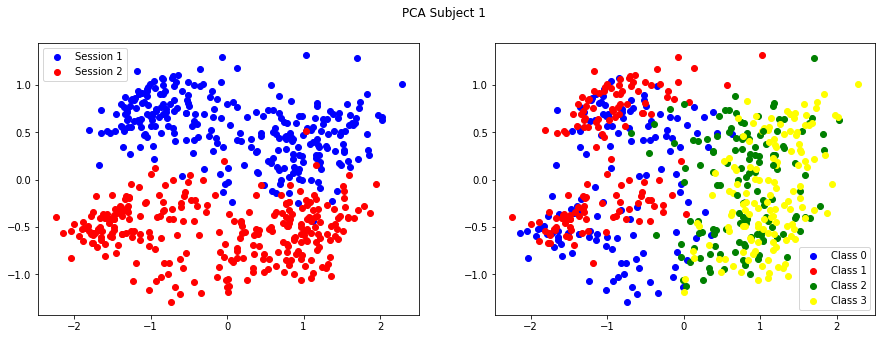

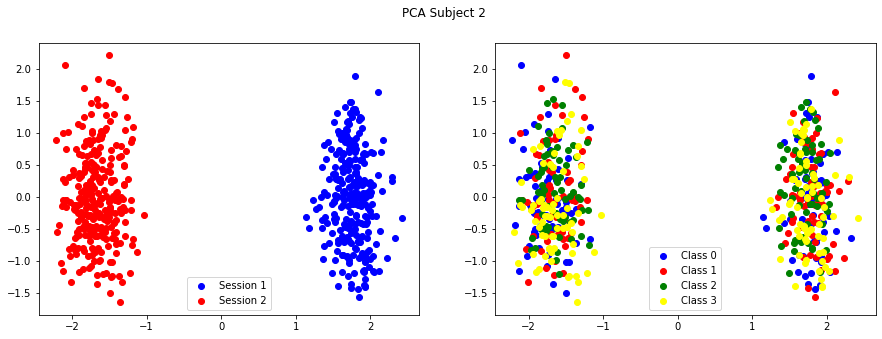

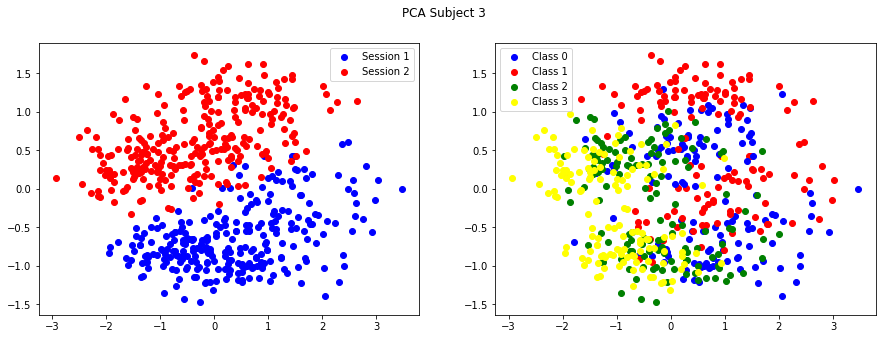

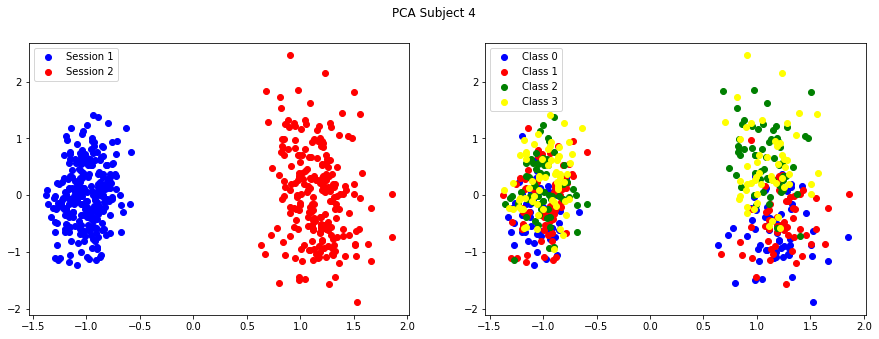

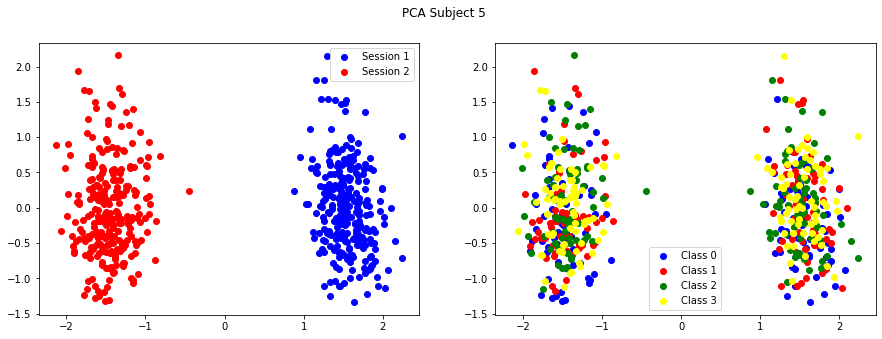

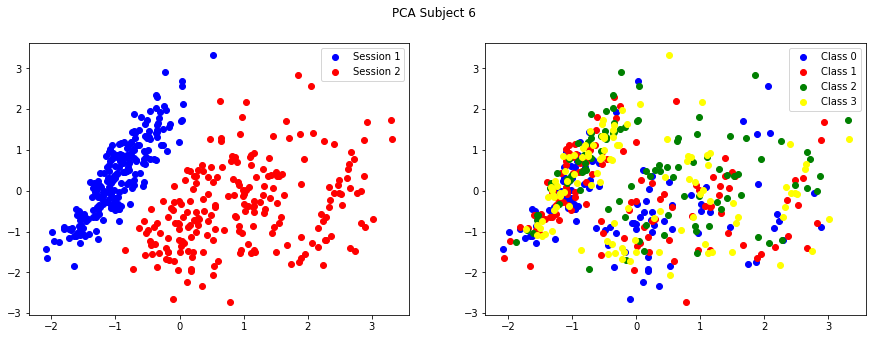

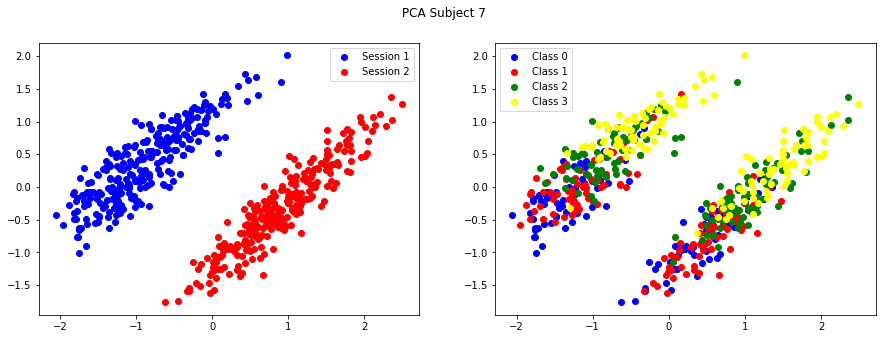

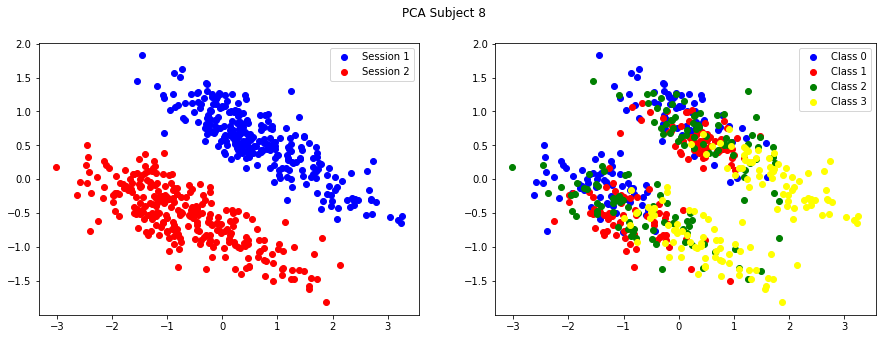

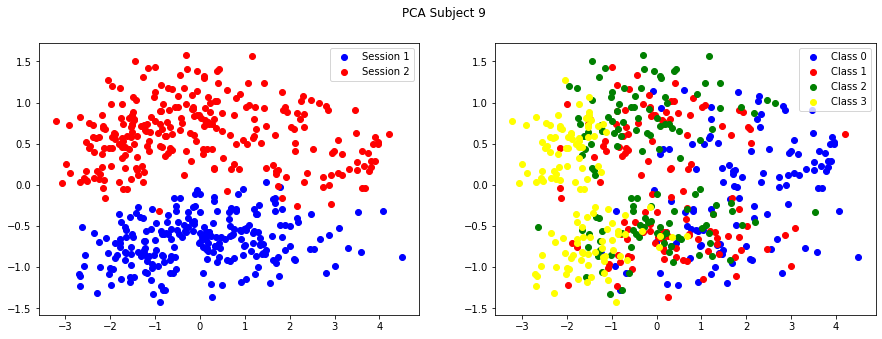

In [4]:
subjects = range(1,10)
for subject in subjects:
    Xs, ys = get_data(subject, True, "./dataset/")
    cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
    ys = torch.tensor(ys, device=device, dtype=torch.long)-1

    Xt, yt = get_data(subject, False, "./dataset/")
    cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
    yt = torch.tensor(yt, device=device, dtype=torch.long)-1
    
    plot_embedding(cov_Xs[:,:,0], cov_Xt[:,:,0], suptitle="PCA Subject "+str(subject), embedding="pca")

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


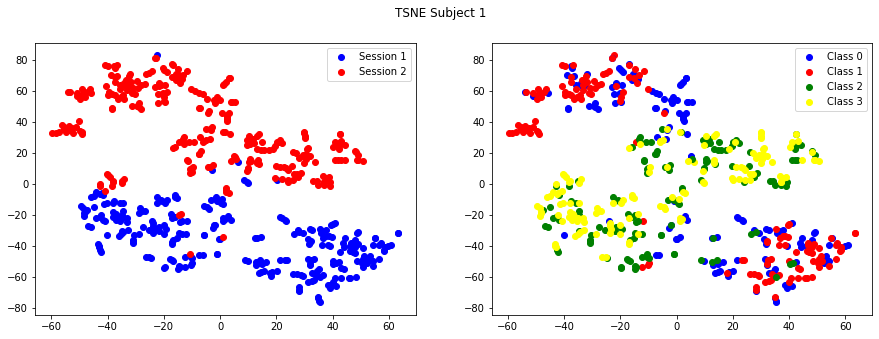

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


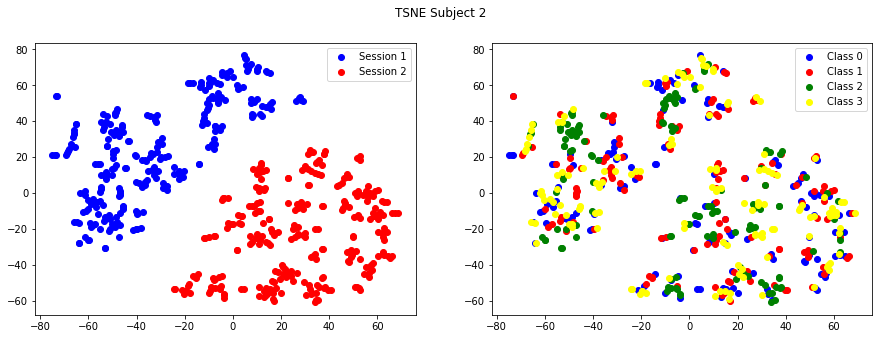

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


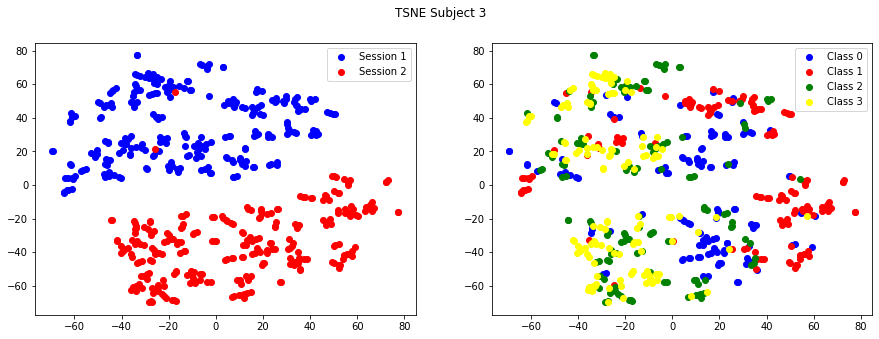

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


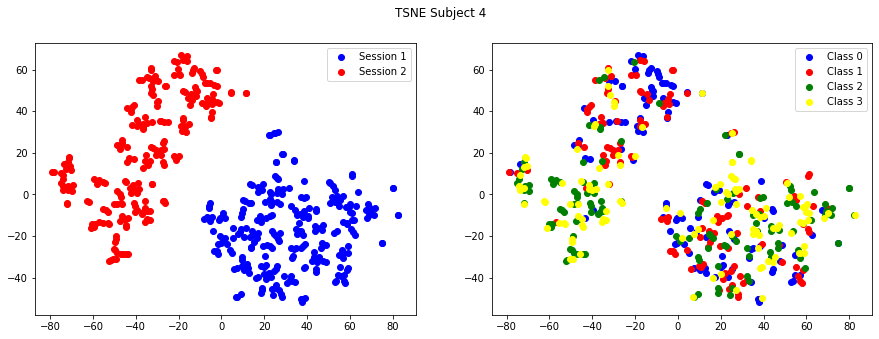

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


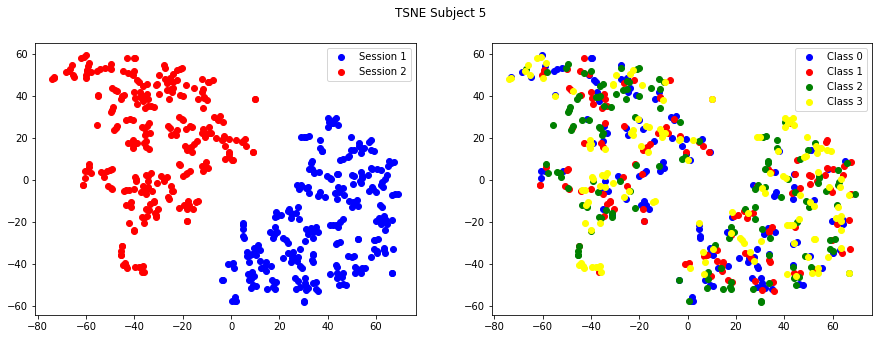

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


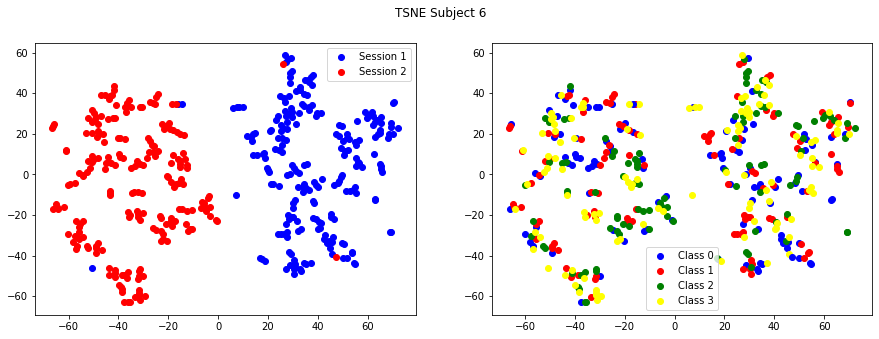

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


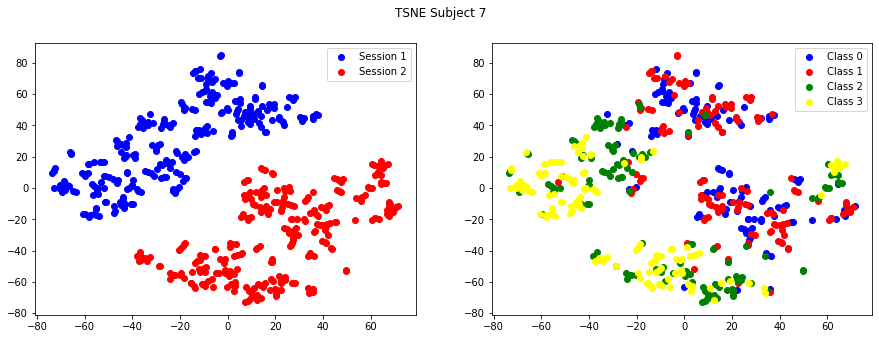

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


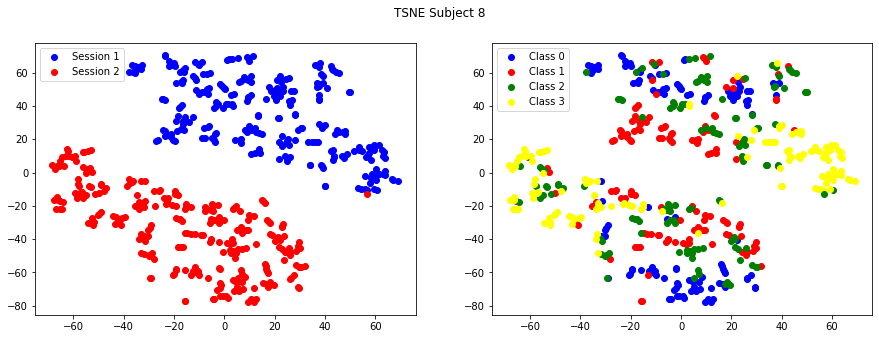

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


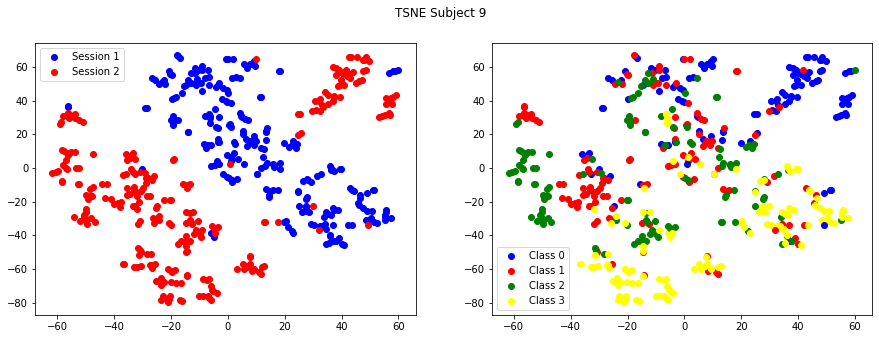

In [5]:
subjects = range(1,10)
for subject in subjects:
    Xs, ys = get_data(subject, True, "./dataset/")
    cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
    ys = torch.tensor(ys, device=device, dtype=torch.long)-1

    Xt, yt = get_data(subject, False, "./dataset/")
    cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
    yt = torch.tensor(yt, device=device, dtype=torch.long)-1
    
    plot_embedding(cov_Xs[:,:,0], cov_Xt[:,:,0], suptitle="TSNE Subject "+str(subject), embedding="tsne")

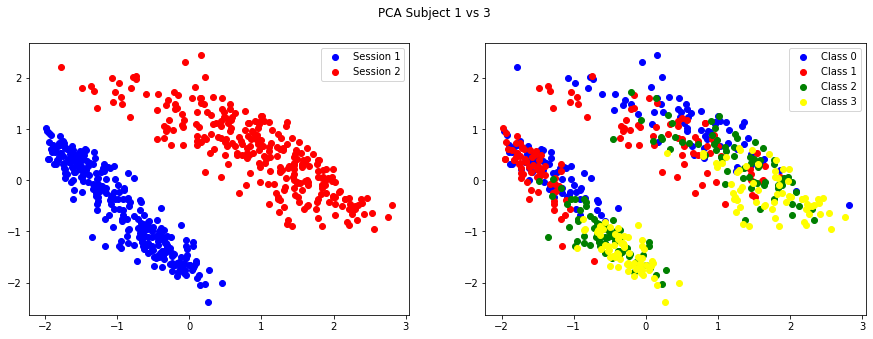

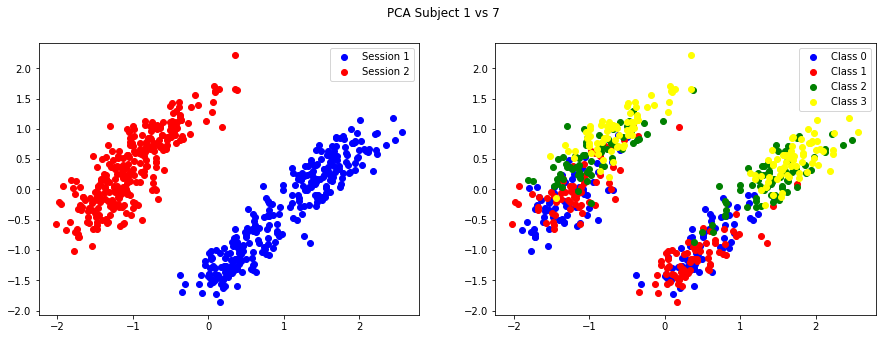

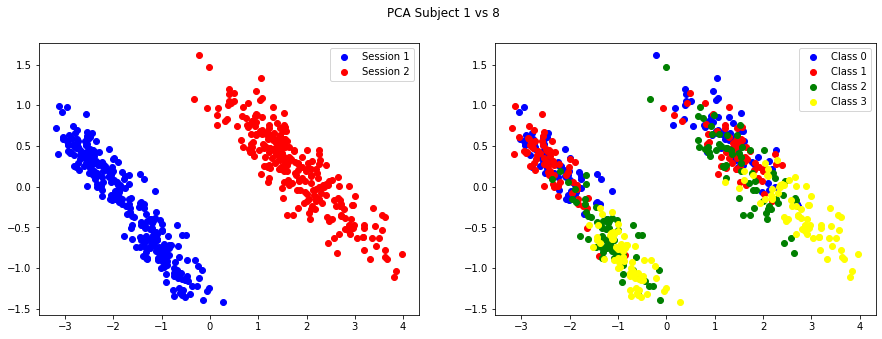

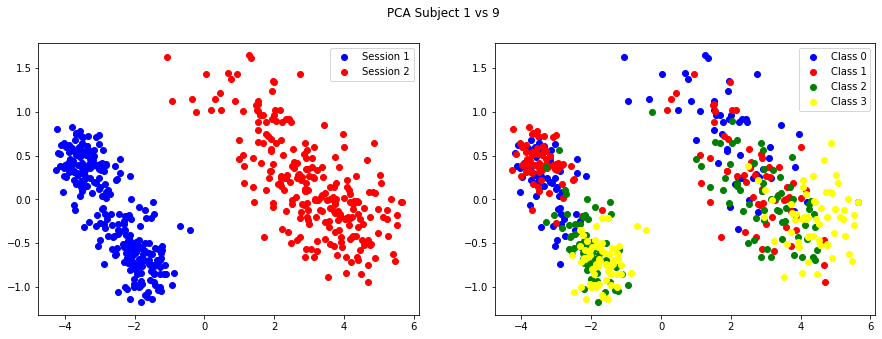

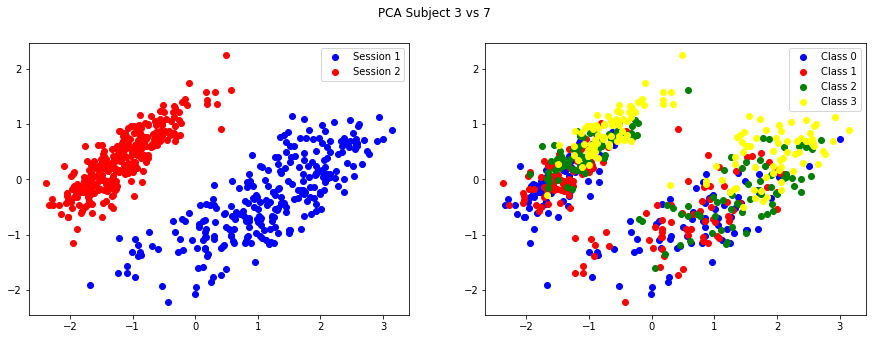

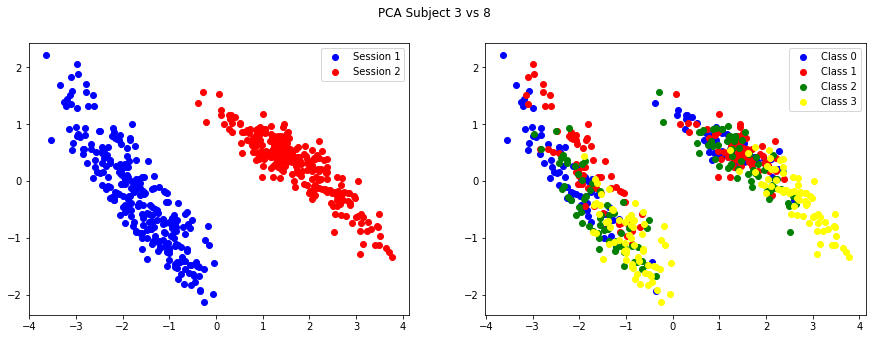

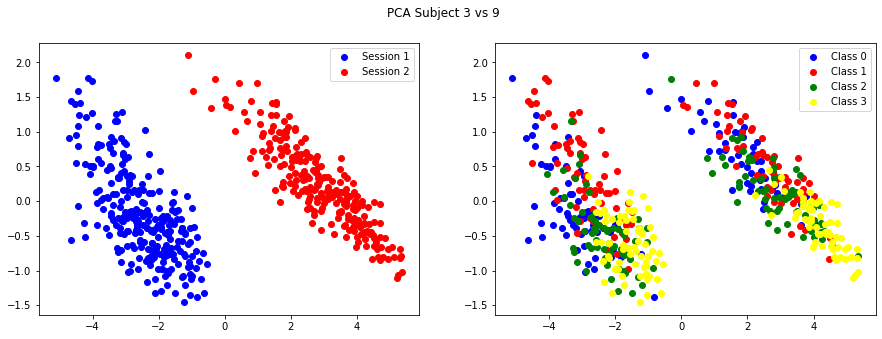

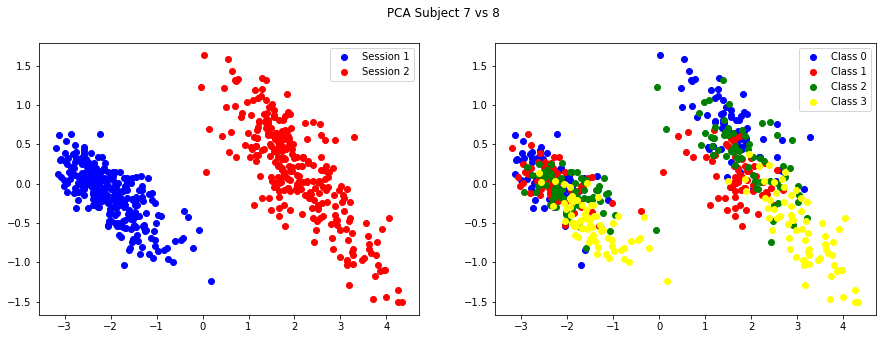

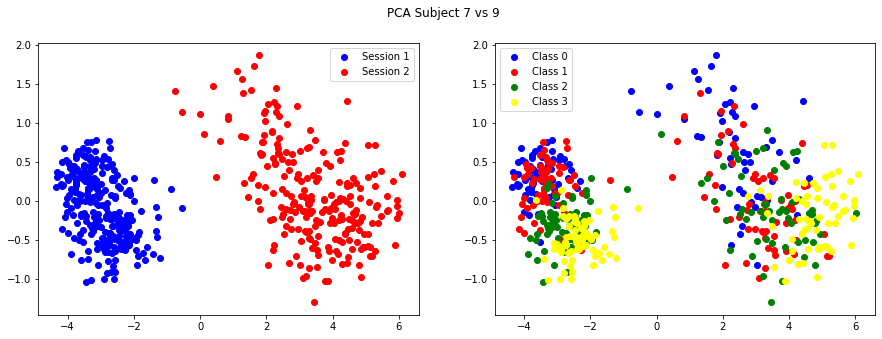

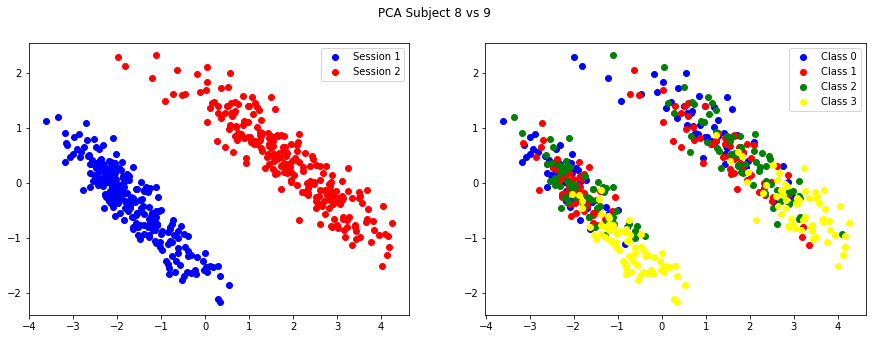

In [6]:
subjects = [1,3,7,8,9]

for i in range(len(subjects)):
    for j in range(i+1,len(subjects)):
        Xs, ys = get_data(subjects[i], True, "./dataset/")
        cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
        ys = torch.tensor(ys, device=device, dtype=torch.long)-1
        
        Xt, yt = get_data(subjects[j], True, "./dataset/")
        cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
        yt = torch.tensor(yt, device=device, dtype=torch.long)-1
        
        plot_embedding(cov_Xs[:,:,0], cov_Xt[:,:,0], suptitle="PCA Subject "+str(subjects[i]) 
                       + " vs " + str(subjects[j]), embedding="pca")

### NN

In [4]:
class SPDNet(nn.Module):
    def __init__(self, d):
        super().__init__()
        
        self.translation1 = Translation(d)
        self.rotation1 = Rotation(d)
        
        self.translation2 = Translation(d)
        self.rotation2 = Rotation(d)
    
    def forward(self, X):
#         Y = self.rotation1(self.translation1(X))
#         Y = self.rotation1(X)
        Y = sym_reeig(self.rotation1(self.translation1(X)))
        Y = self.rotation2(self.translation2(Y))
        
        return Y

In [5]:
class Transformations(nn.Module):
    def __init__(self, d):
        super().__init__()
        
        self.translation1 = Translation(d)
        self.rotation1 = Rotation(d)
    
    def forward(self, X):
        Y = self.rotation1(self.translation1(X))
        
        return Y

### Subject 1 to 3

In [9]:
Xs, ys = get_data(1, True, "./dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(3, True, "./dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1

In [10]:
epochs = 500
num_projs = 500

# model = SPDNet(22).to(device)
model = Transformations(22).to(device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

L_loss = []

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,0])
    loss = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    L_loss.append(loss.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f}")

100%|███████████████████████████| 500/500 [02:12<00:00,  3.76it/s, loss = 0.005]


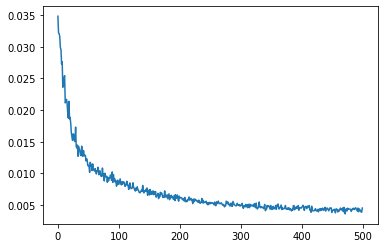

In [11]:
plt.plot(L_loss)
plt.show()

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


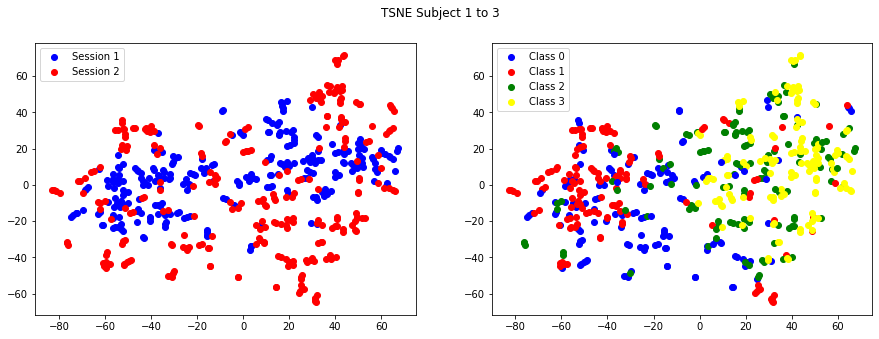

In [12]:
plot_embedding(model(cov_Xs[:,:,0]), cov_Xt[:,:,0], suptitle="TSNE Subject 1 to 3", embedding="tsne")

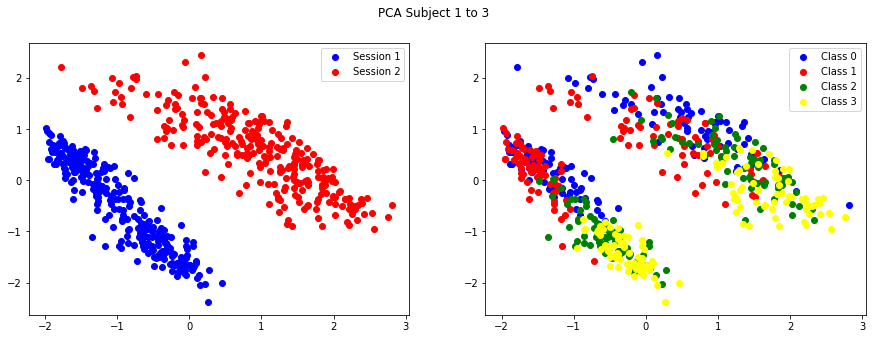

In [13]:
plot_embedding(cov_Xs[:,:,0], cov_Xt[:,:,0], suptitle="PCA Subject 1 to 3", embedding="pca")

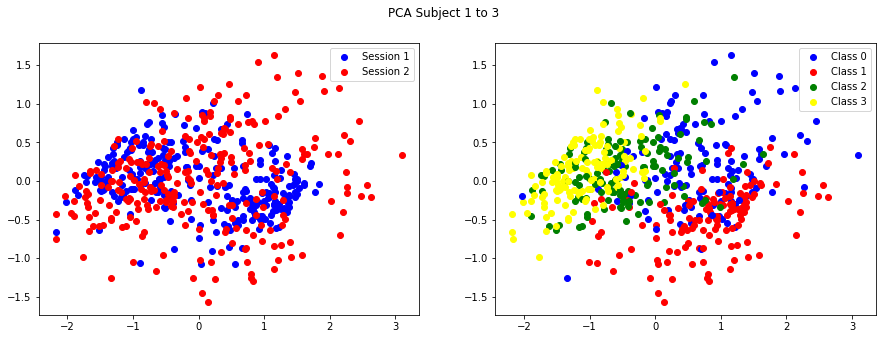

In [14]:
plot_embedding(model(cov_Xs[:,:,0]), cov_Xt[:,:,0], suptitle="PCA Subject 1 to 3", embedding="pca")

In [15]:
d = 22

components = range(2,200)

L_sc = []
L_tgt = []

log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0]).detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0].detach().cpu()).reshape(-1, d*d)

for n in components:
    clf = make_pipeline(PCA(n), GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))

    clf.fit(log_Xs, ys)
    L_tgt.append(clf.score(log_Xt, yt))
    L_sc.append(clf.score(log_Xs, ys))

In [16]:
components = range(2,200)
L2_sc = []
L2_tgt = []

log_Xs = linalg.sym_logm(cov_Xs[:,0,0].detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0].detach().cpu()).reshape(-1, d*d)

for n in components:
    clf = make_pipeline(PCA(n), GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))

    clf.fit(log_Xs, ys)
    L2_tgt.append(clf.score(log_Xt, yt))
    L2_sc.append(clf.score(log_Xs, ys))

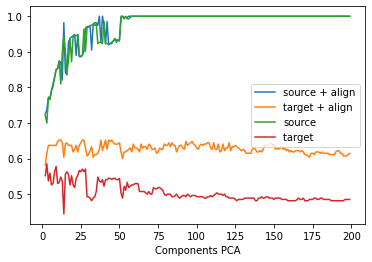

In [17]:
plt.plot(components, L_sc, label="source + align")
plt.plot(components, L_tgt, label="target + align ")

plt.plot(components, L2_sc, label="source")
plt.plot(components, L2_tgt, label="target ")

plt.xlabel("Components PCA")
plt.legend()
plt.show()

In [18]:
np.max(L_tgt)

0.6518518518518519

In [19]:
## LR on original data

log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

lr = LogisticRegressionCV(Cs=10, max_iter=1000, n_jobs=10)
lr.fit(log_Xs, ys.cpu())
lr.score(log_Xt, yt.cpu())

0.5222222222222223

In [20]:
## LR on shifted data

log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

lr = LogisticRegressionCV(Cs=10, max_iter=1000, n_jobs=10)
lr.fit(log_Xs, ys.cpu())
lr.score(log_Xt, yt.cpu())

0.6518518518518519

### SVC between Subjects

#### SWSPD

In [21]:
results0 = np.zeros((5,5))
results1 = np.zeros((5,5))

d = 22

for i, s1 in enumerate([1,3,7,8,9]):
    for j, s2 in enumerate([1,3,7,8,9]):
        if s1 != s2:
            Xs, ys = get_data(s1, True, "./dataset/")
            cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
            ys = torch.tensor(ys, device=device, dtype=torch.long)-1

            Xt, yt = get_data(s2, True, "./dataset/")
            cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
            yt = torch.tensor(yt, device=device, dtype=torch.long)-1


            epochs = 500
            num_projs = 500

            model = Transformations(22).to(device)
            optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
            # optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

            L_loss = []

            pbar = trange(epochs)

            for e in pbar:
                zs = model(cov_Xs[:,:,0])
                loss = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                L_loss.append(loss.item())

                pbar.set_postfix_str(f"loss = {loss.item():.3f}")



            ## LR on original data
            log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score0 = clf.score(log_Xt, yt.cpu())


            ## LR on shifted data
            log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score1 = clf.score(log_Xt, yt.cpu())

            print(s1, s2, score0, score1)
            results0[i,j] = score0
            results1[i,j] = score1

100%|███████████████████████████| 500/500 [04:00<00:00,  2.08it/s, loss = 0.004]


1 3 0.5111111111111111 0.6074074074074074


100%|███████████████████████████| 500/500 [04:02<00:00,  2.06it/s, loss = 0.002]


1 7 0.3173431734317343 0.44649446494464945


100%|███████████████████████████| 500/500 [03:59<00:00,  2.09it/s, loss = 0.002]


1 8 0.30303030303030304 0.6287878787878788


100%|███████████████████████████| 500/500 [03:49<00:00,  2.18it/s, loss = 0.012]


1 9 0.25316455696202533 0.5021097046413502


100%|███████████████████████████| 500/500 [03:59<00:00,  2.08it/s, loss = 0.004]


3 1 0.3553113553113553 0.6373626373626373


100%|███████████████████████████| 500/500 [03:59<00:00,  2.09it/s, loss = 0.008]


3 7 0.24354243542435425 0.5719557195571956


100%|███████████████████████████| 500/500 [03:57<00:00,  2.11it/s, loss = 0.003]


3 8 0.4015151515151515 0.6590909090909091


100%|███████████████████████████| 500/500 [03:50<00:00,  2.17it/s, loss = 0.005]


3 9 0.28270042194092826 0.5569620253164557


100%|███████████████████████████| 500/500 [03:29<00:00,  2.39it/s, loss = 0.002]


7 1 0.43956043956043955 0.42124542124542125


100%|███████████████████████████| 500/500 [02:11<00:00,  3.81it/s, loss = 0.007]


7 3 0.45185185185185184 0.5407407407407407


100%|███████████████████████████| 500/500 [02:08<00:00,  3.89it/s, loss = 0.003]


7 8 0.2803030303030303 0.35984848484848486


100%|███████████████████████████| 500/500 [02:04<00:00,  4.01it/s, loss = 0.017]


7 9 0.2616033755274262 0.4767932489451477


100%|███████████████████████████| 500/500 [02:09<00:00,  3.86it/s, loss = 0.002]


8 1 0.304029304029304 0.5164835164835165


100%|███████████████████████████| 500/500 [02:05<00:00,  3.99it/s, loss = 0.004]


8 3 0.2814814814814815 0.6962962962962963


100%|███████████████████████████| 500/500 [02:03<00:00,  4.04it/s, loss = 0.003]


8 7 0.2656826568265683 0.4132841328413284


100%|███████████████████████████| 500/500 [02:03<00:00,  4.06it/s, loss = 0.009]


8 9 0.3291139240506329 0.5527426160337553


100%|███████████████████████████| 500/500 [01:59<00:00,  4.20it/s, loss = 0.012]


9 1 0.26373626373626374 0.4945054945054945


100%|███████████████████████████| 500/500 [01:58<00:00,  4.23it/s, loss = 0.005]


9 3 0.3148148148148148 0.5851851851851851


100%|███████████████████████████| 500/500 [02:00<00:00,  4.16it/s, loss = 0.015]


9 7 0.24723247232472326 0.3726937269372694


100%|███████████████████████████| 500/500 [01:56<00:00,  4.28it/s, loss = 0.008]


9 8 0.3560606060606061 0.5492424242424242


In [22]:
results1

array([[0.        , 0.60740741, 0.44649446, 0.62878788, 0.5021097 ],
       [0.63736264, 0.        , 0.57195572, 0.65909091, 0.55696203],
       [0.42124542, 0.54074074, 0.        , 0.35984848, 0.47679325],
       [0.51648352, 0.6962963 , 0.41328413, 0.        , 0.55274262],
       [0.49450549, 0.58518519, 0.37269373, 0.54924242, 0.        ]])

In [23]:
results0

array([[0.        , 0.51111111, 0.31734317, 0.3030303 , 0.25316456],
       [0.35531136, 0.        , 0.24354244, 0.40151515, 0.28270042],
       [0.43956044, 0.45185185, 0.        , 0.28030303, 0.26160338],
       [0.3040293 , 0.28148148, 0.26568266, 0.        , 0.32911392],
       [0.26373626, 0.31481481, 0.24723247, 0.35606061, 0.        ]])

In [24]:
for k, row in enumerate(results0):
    print(k, np.sum(row)/4)

0 0.3461622861337934
1 0.32076734104794735
2 0.35832967431068696
3 0.29507684159699665
4 0.29546103923410194


In [25]:
for k, row in enumerate(results1):
    print(k, np.sum(row)/4)

0 0.5461998639453214
1 0.6063428228317994
2 0.44965697394494863
3 0.5447016404137242
4 0.5004067077175933


#### LEW

In [26]:
results0 = np.zeros((5,5))
results1 = np.zeros((5,5))

d = 22

manifold_spdai = geoopt.SymmetricPositiveDefinite("LEM")        


for i, s1 in enumerate([1,3,7,8,9]):
    for j, s2 in enumerate([1,3,7,8,9]):
        if s1 != s2:
            Xs, ys = get_data(s1, True, "./dataset/")
            cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
            ys = torch.tensor(ys, device=device, dtype=torch.long)-1

            Xt, yt = get_data(s2, True, "./dataset/")
            cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
            yt = torch.tensor(yt, device=device, dtype=torch.long)-1


            epochs = 500 #500
            num_projs = 500

            model = Transformations(22).to(device)
            optimizer = RiemannianSGD(model.parameters(), lr=1e-2)
            # optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

            L_loss = []

            pbar = trange(epochs)

            for e in pbar:
                zs = model(cov_Xs[:,:,0])
                
                a = torch.ones((len(zs),), device=device, dtype=torch.float64)/len(zs)
                b = torch.ones((len(cov_Xt),), device=device, dtype=torch.float64)/len(cov_Xt)
                M = manifold_spdai.dist(zs[:,0][:,None], cov_Xt[:,0,0][None])**2
                loss = 0.1 * ot.emd2(a, b, M)
                
#                 loss = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                L_loss.append(loss.item())

                pbar.set_postfix_str(f"loss = {loss.item():.3f}")



            ## LR on original data
            log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score0 = clf.score(log_Xt, yt.cpu())


            ## LR on shifted data
            log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score1 = clf.score(log_Xt, yt.cpu())

            print(s1, s2, score0, score1)
            results0[i,j] = score0
            results1[i,j] = score1

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/geoopt/manifolds/symmetric_positive_definite.py:52: UserWarning: SPDMetric.LEM is not fully implemented and results may be not as you expect
  warnings.warn(
100%|███████████████████████████| 500/500 [01:27<00:00,  5.68it/s, loss = 0.684]


1 3 0.5111111111111111 0.6259259259259259


100%|███████████████████████████| 500/500 [01:16<00:00,  6.55it/s, loss = 0.584]


1 7 0.3173431734317343 0.44649446494464945


100%|███████████████████████████| 500/500 [01:29<00:00,  5.59it/s, loss = 0.662]


1 8 0.30303030303030304 0.6136363636363636


100%|███████████████████████████| 500/500 [01:21<00:00,  6.17it/s, loss = 0.745]


1 9 0.25316455696202533 0.47257383966244726


100%|███████████████████████████| 500/500 [01:32<00:00,  5.43it/s, loss = 0.675]


3 1 0.3553113553113553 0.6446886446886447


100%|███████████████████████████| 500/500 [01:31<00:00,  5.49it/s, loss = 0.672]


3 7 0.24354243542435425 0.5756457564575646


100%|███████████████████████████| 500/500 [01:17<00:00,  6.44it/s, loss = 0.733]


3 8 0.4015151515151515 0.6628787878787878


100%|███████████████████████████| 500/500 [01:17<00:00,  6.48it/s, loss = 0.793]


3 9 0.28270042194092826 0.5611814345991561


100%|███████████████████████████| 500/500 [01:15<00:00,  6.61it/s, loss = 0.566]


7 1 0.43956043956043955 0.4139194139194139


100%|███████████████████████████| 500/500 [01:31<00:00,  5.47it/s, loss = 0.660]


7 3 0.45185185185185184 0.5518518518518518


100%|███████████████████████████| 500/500 [01:27<00:00,  5.68it/s, loss = 0.643]


7 8 0.2803030303030303 0.36363636363636365


100%|███████████████████████████| 500/500 [01:22<00:00,  6.04it/s, loss = 0.732]


7 9 0.2616033755274262 0.47257383966244726


100%|███████████████████████████| 500/500 [01:29<00:00,  5.57it/s, loss = 0.673]


8 1 0.304029304029304 0.5091575091575091


100%|███████████████████████████| 500/500 [01:30<00:00,  5.52it/s, loss = 0.757]


8 3 0.2814814814814815 0.7074074074074074


100%|███████████████████████████| 500/500 [01:29<00:00,  5.58it/s, loss = 0.676]


8 7 0.2656826568265683 0.4059040590405904


100%|███████████████████████████| 500/500 [01:19<00:00,  6.32it/s, loss = 0.783]


8 9 0.3291139240506329 0.5822784810126582


100%|███████████████████████████| 500/500 [01:22<00:00,  6.09it/s, loss = 0.786]


9 1 0.26373626373626374 0.5054945054945055


100%|███████████████████████████| 500/500 [01:22<00:00,  6.07it/s, loss = 0.844]


9 3 0.3148148148148148 0.6444444444444445


100%|███████████████████████████| 500/500 [01:21<00:00,  6.15it/s, loss = 0.797]


9 7 0.24723247232472326 0.3874538745387454


100%|███████████████████████████| 500/500 [01:20<00:00,  6.19it/s, loss = 0.808]


9 8 0.3560606060606061 0.571969696969697


In [27]:
results1

array([[0.        , 0.62592593, 0.44649446, 0.61363636, 0.47257384],
       [0.64468864, 0.        , 0.57564576, 0.66287879, 0.56118143],
       [0.41391941, 0.55185185, 0.        , 0.36363636, 0.47257384],
       [0.50915751, 0.70740741, 0.40590406, 0.        , 0.58227848],
       [0.50549451, 0.64444444, 0.38745387, 0.5719697 , 0.        ]])

In [28]:
results0

array([[0.        , 0.51111111, 0.31734317, 0.3030303 , 0.25316456],
       [0.35531136, 0.        , 0.24354244, 0.40151515, 0.28270042],
       [0.43956044, 0.45185185, 0.        , 0.28030303, 0.26160338],
       [0.3040293 , 0.28148148, 0.26568266, 0.        , 0.32911392],
       [0.26373626, 0.31481481, 0.24723247, 0.35606061, 0.        ]])

In [29]:
for k, row in enumerate(results0):
    print(k, np.sum(row)/4)

0 0.3461622861337934
1 0.32076734104794735
2 0.35832967431068696
3 0.29507684159699665
4 0.29546103923410194


In [30]:
for k, row in enumerate(results1):
    print(k, np.sum(row)/4)

0 0.5396576485423465
1 0.6110986559060383
2 0.45049536726751915
3 0.5511868641545412
4 0.5273406303618481


#### SW

In [31]:
from vecswspd import sliced_wasserstein_vecspd

In [32]:
results0 = np.zeros((5,5))
results1 = np.zeros((5,5))

d = 22

for i, s1 in enumerate([1,3,7,8,9]):
    for j, s2 in enumerate([1,3,7,8,9]):
        if s1 != s2:
            Xs, ys = get_data(s1, True, "./dataset/")
            cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
            ys = torch.tensor(ys, device=device, dtype=torch.long)-1

            Xt, yt = get_data(s2, True, "./dataset/")
            cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
            yt = torch.tensor(yt, device=device, dtype=torch.long)-1


            epochs = 2000 #500
            num_projs = 500

            model = Transformations(22).to(device)
            optimizer = RiemannianSGD(model.parameters(), lr=1e-5)
            # optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

            L_loss = []

            pbar = trange(epochs)

            for e in pbar:
                if torch.any(torch.isnan(zs)):
                    print(zs)
                zs = model(cov_Xs[:,:,0])
                loss = sliced_wasserstein_vecspd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                L_loss.append(loss.item())

                pbar.set_postfix_str(f"loss = {loss.item():.3f}")



            ## LR on original dat5
            log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score0 = clf.score(log_Xt, yt.cpu())


            ## LR on shifted data
            log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score1 = clf.score(log_Xt, yt.cpu())

            print(s1, s2, score0, score1)
            results0[i,j] = score0
            results1[i,j] = score1

100%|████████████████████████| 2000/2000 [01:32<00:00, 21.55it/s, loss = 29.698]


1 3 0.5111111111111111 0.5222222222222223


100%|█████████████████████████| 2000/2000 [01:32<00:00, 21.55it/s, loss = 1.653]


1 7 0.3173431734317343 0.42435424354243545


100%|████████████████████████| 2000/2000 [01:29<00:00, 22.44it/s, loss = 36.305]


1 8 0.30303030303030304 0.4015151515151515


100%|████████████████████████| 2000/2000 [01:20<00:00, 24.71it/s, loss = 51.096]


1 9 0.25316455696202533 0.26582278481012656


100%|█████████████████████████| 2000/2000 [01:24<00:00, 23.54it/s, loss = 8.848]


3 1 0.3553113553113553 0.46153846153846156


100%|█████████████████████████| 2000/2000 [01:26<00:00, 23.21it/s, loss = 5.008]


3 7 0.24354243542435425 0.3800738007380074


100%|████████████████████████| 2000/2000 [01:28<00:00, 22.52it/s, loss = 26.839]


3 8 0.4015151515151515 0.4621212121212121


100%|████████████████████████| 2000/2000 [01:22<00:00, 24.25it/s, loss = 58.322]


3 9 0.28270042194092826 0.33755274261603374


100%|█████████████████████████| 2000/2000 [01:28<00:00, 22.70it/s, loss = 2.655]


7 1 0.43956043956043955 0.42857142857142855


100%|████████████████████████| 2000/2000 [01:25<00:00, 23.34it/s, loss = 17.604]


7 3 0.45185185185185184 0.43703703703703706


100%|████████████████████████| 2000/2000 [01:25<00:00, 23.45it/s, loss = 35.392]


7 8 0.2803030303030303 0.25757575757575757


100%|████████████████████████| 2000/2000 [01:20<00:00, 24.70it/s, loss = 63.816]


7 9 0.2616033755274262 0.25738396624472576


100%|█████████████████████████| 2000/2000 [01:23<00:00, 24.02it/s, loss = 6.974]


8 1 0.304029304029304 0.42124542124542125


100%|████████████████████████| 2000/2000 [01:27<00:00, 22.81it/s, loss = 10.115]


8 3 0.2814814814814815 0.37407407407407406


100%|█████████████████████████| 2000/2000 [01:25<00:00, 23.42it/s, loss = 5.501]


8 7 0.2656826568265683 0.25461254612546125


100%|████████████████████████| 2000/2000 [01:22<00:00, 24.15it/s, loss = 37.662]


8 9 0.3291139240506329 0.4388185654008439


100%|████████████████████████| 2000/2000 [01:21<00:00, 24.63it/s, loss = 18.373]


9 1 0.26373626373626374 0.2857142857142857


100%|████████████████████████| 2000/2000 [01:20<00:00, 24.79it/s, loss = 18.424]


9 3 0.3148148148148148 0.35185185185185186


100%|████████████████████████| 2000/2000 [01:19<00:00, 25.11it/s, loss = 10.608]


9 7 0.24723247232472326 0.24723247232472326


100%|████████████████████████| 2000/2000 [01:19<00:00, 25.06it/s, loss = 24.315]


9 8 0.3560606060606061 0.4053030303030303


In [33]:
results1

array([[0.        , 0.52222222, 0.42435424, 0.40151515, 0.26582278],
       [0.46153846, 0.        , 0.3800738 , 0.46212121, 0.33755274],
       [0.42857143, 0.43703704, 0.        , 0.25757576, 0.25738397],
       [0.42124542, 0.37407407, 0.25461255, 0.        , 0.43881857],
       [0.28571429, 0.35185185, 0.24723247, 0.40530303, 0.        ]])

In [34]:
results0

array([[0.        , 0.51111111, 0.31734317, 0.3030303 , 0.25316456],
       [0.35531136, 0.        , 0.24354244, 0.40151515, 0.28270042],
       [0.43956044, 0.45185185, 0.        , 0.28030303, 0.26160338],
       [0.3040293 , 0.28148148, 0.26568266, 0.        , 0.32911392],
       [0.26373626, 0.31481481, 0.24723247, 0.35606061, 0.        ]])

In [35]:
for k, row in enumerate(results0):
    print(k, np.sum(row)/4)

0 0.3461622861337934
1 0.32076734104794735
2 0.35832967431068696
3 0.29507684159699665
4 0.29546103923410194


In [36]:
for k, row in enumerate(results1):
    print(k, np.sum(row)/4)

0 0.40347860052248397
1 0.41032155425342876
2 0.34514204735723725
3 0.3721876517114501
4 0.3225254100484728


#### SW Matrix

In [19]:
results0 = np.zeros((5,5))
results1 = np.zeros((5,5))

d = 22

for i, s1 in enumerate([1,3,7,8,9]):
    for j, s2 in enumerate([1,3,7,8,9]):
        if s1 != s2:
            Xs, ys = get_data(s1, True, "./dataset/")
            cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
            ys = torch.tensor(ys, device=device, dtype=torch.long)-1

            Xt, yt = get_data(s2, True, "./dataset/")
            cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
            yt = torch.tensor(yt, device=device, dtype=torch.long)-1


            epochs = 500
            num_projs = 500

            model = Transformations(22).to(device)
            optimizer = RiemannianSGD(model.parameters(), lr=1e-6)
            # optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

            L_loss = []

            pbar = trange(epochs)

            for e in pbar:
                zs = model(cov_Xs[:,:,0])
                loss = sliced_wasserstein_matrix(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                L_loss.append(loss.item())

                pbar.set_postfix_str(f"loss = {loss.item():.3f}")



            ## LR on original data
            log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score0 = clf.score(log_Xt, yt.cpu())


            ## LR on shifted data
            log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score1 = clf.score(log_Xt, yt.cpu())

            print(s1, s2, score0, score1)
            results0[i,j] = score0
            results1[i,j] = score1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:11<00:00,  1.99it/s, loss = 30.799]


1 3 0.5111111111111111 0.5222222222222223


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:11<00:00,  1.98it/s, loss = 4.761]


1 7 0.3173431734317343 0.33948339483394835


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:09<00:00,  2.00it/s, loss = 104.795]


1 8 0.30303030303030304 0.32196969696969696


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:59<00:00,  2.09it/s, loss = 426.211]


1 9 0.25316455696202533 0.25316455696202533


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:08<00:00,  2.01it/s, loss = 12.103]


3 1 0.3553113553113553 0.37362637362637363


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:08<00:00,  2.01it/s, loss = 11.970]


3 7 0.24354243542435425 0.25830258302583026


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:26<00:00,  2.43it/s, loss = 73.562]


3 8 0.4015151515151515 0.4090909090909091


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:00<00:00,  4.13it/s, loss = 287.565]


3 9 0.28270042194092826 0.28270042194092826


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:07<00:00,  2.66it/s, loss = 5.653]


7 1 0.43956043956043955 0.4542124542124542


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:13<00:00,  1.98it/s, loss = 29.510]


7 3 0.45185185185185184 0.4444444444444444


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:11<00:00,  1.99it/s, loss = 139.342]


7 8 0.2803030303030303 0.25757575757575757


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:03<00:00,  2.05it/s, loss = 437.584]


7 9 0.2616033755274262 0.25738396624472576


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:10<00:00,  2.00it/s, loss = 43.280]


8 1 0.304029304029304 0.358974358974359


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:11<00:00,  1.99it/s, loss = 39.428]


8 3 0.2814814814814815 0.28888888888888886


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:09<00:00,  2.01it/s, loss = 52.341]


8 7 0.2656826568265683 0.25830258302583026


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:00<00:00,  2.07it/s, loss = 105.722]


8 9 0.3291139240506329 0.37130801687763715


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:56<00:00,  2.12it/s, loss = 118.895]


9 1 0.26373626373626374 0.2600732600732601


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:56<00:00,  2.11it/s, loss = 108.551]


9 3 0.3148148148148148 0.3037037037037037


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:55<00:00,  2.12it/s, loss = 126.523]


9 7 0.24723247232472326 0.24723247232472326


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:54<00:00,  2.13it/s, loss = 65.558]


9 8 0.3560606060606061 0.3484848484848485


In [20]:
results1

array([[0.        , 0.52222222, 0.33948339, 0.3219697 , 0.25316456],
       [0.37362637, 0.        , 0.25830258, 0.40909091, 0.28270042],
       [0.45421245, 0.44444444, 0.        , 0.25757576, 0.25738397],
       [0.35897436, 0.28888889, 0.25830258, 0.        , 0.37130802],
       [0.26007326, 0.3037037 , 0.24723247, 0.34848485, 0.        ]])

In [21]:
results0

array([[0.        , 0.51111111, 0.31734317, 0.3030303 , 0.25316456],
       [0.35531136, 0.        , 0.24354244, 0.40151515, 0.28270042],
       [0.43956044, 0.45185185, 0.        , 0.28030303, 0.26160338],
       [0.3040293 , 0.28148148, 0.26568266, 0.        , 0.32911392],
       [0.26373626, 0.31481481, 0.24723247, 0.35606061, 0.        ]])

In [22]:
for k, row in enumerate(results0):
    print(k, np.sum(row)/4)

0 0.3461622861337934
1 0.32076734104794735
2 0.35832967431068696
3 0.29507684159699665
4 0.29546103923410194


In [23]:
for k, row in enumerate(results1):
    print(k, np.sum(row)/4)

0 0.3592099677469732
1 0.3309300719210103
2 0.35340415561934546
3 0.3193684619416788
4 0.2898735711466339


#### SW Matrix + Log

In [8]:
results0 = np.zeros((5,5))
results1 = np.zeros((5,5))

d = 22

for i, s1 in enumerate([1,3,7,8,9]):
    for j, s2 in enumerate([1,3,7,8,9]):
            if s1 != s2:
                Xs, ys = get_data(s1, True, "./dataset/")
                cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
                ys = torch.tensor(ys, device=device, dtype=torch.long)-1

                Xt, yt = get_data(s2, True, "./dataset/")
                cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
                yt = torch.tensor(yt, device=device, dtype=torch.long)-1


            epochs = 500
            num_projs = 500

            model = Transformations(22).to(device)
            optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
            # optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

            L_loss = []

            pbar = trange(epochs)

            for e in pbar:
                zs = model(cov_Xs[:,:,0])
                loss = sliced_wasserstein_logmatrix(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                L_loss.append(loss.item())

                pbar.set_postfix_str(f"loss = {loss.item():.3f}")



            ## LR on original data
            log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score0 = clf.score(log_Xt, yt.cpu())


            ## LR on shifted data
            log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score1 = clf.score(log_Xt, yt.cpu())

            print(s1, s2, score0, score1)
            results0[i,j] = score0
            results1[i,j] = score1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:32<00:00,  1.84it/s, loss = 0.001]


1 3 0.5111111111111111 0.6037037037037037


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:31<00:00,  1.84it/s, loss = 0.001]


1 7 0.3173431734317343 0.4022140221402214


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:30<00:00,  1.85it/s, loss = 0.003]


1 8 0.30303030303030304 0.5227272727272727


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:22<00:00,  1.90it/s, loss = 0.013]


1 9 0.25316455696202533 0.3881856540084388


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:18<00:00,  3.60it/s, loss = 0.001]


3 1 0.3553113553113553 0.6263736263736264


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:21<00:00,  3.54it/s, loss = 0.002]


3 7 0.24354243542435425 0.5535055350553506


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:20<00:00,  3.57it/s, loss = 0.002]


3 8 0.4015151515151515 0.678030303030303


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:07<00:00,  3.93it/s, loss = 0.010]


3 9 0.28270042194092826 0.4008438818565401


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:19<00:00,  3.58it/s, loss = 0.001]


7 1 0.43956043956043955 0.4249084249084249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:31<00:00,  3.30it/s, loss = 0.002]


7 3 0.45185185185185184 0.5333333333333333


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:27<00:00,  1.87it/s, loss = 0.005]


7 8 0.2803030303030303 0.4128787878787879


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:20<00:00,  1.92it/s, loss = 0.016]


7 9 0.2616033755274262 0.4092827004219409


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:26<00:00,  1.88it/s, loss = 0.003]


8 1 0.304029304029304 0.43956043956043955


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:25<00:00,  1.88it/s, loss = 0.003]


8 3 0.2814814814814815 0.6111111111111112


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:26<00:00,  1.87it/s, loss = 0.005]


8 7 0.2656826568265683 0.31365313653136534


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:17<00:00,  1.94it/s, loss = 0.004]


8 9 0.3291139240506329 0.5063291139240507


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:11<00:00,  1.99it/s, loss = 0.012]


9 1 0.26373626373626374 0.3882783882783883


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:11<00:00,  1.99it/s, loss = 0.009]


9 3 0.3148148148148148 0.44074074074074077


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:12<00:00,  1.98it/s, loss = 0.015]


9 7 0.24723247232472326 0.23616236162361623


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:10<00:00,  2.00it/s, loss = 0.004]


9 8 0.3560606060606061 0.4431818181818182


In [9]:
results1

array([[0.        , 0.6037037 , 0.40221402, 0.52272727, 0.38818565],
       [0.62637363, 0.        , 0.55350554, 0.6780303 , 0.40084388],
       [0.42490842, 0.53333333, 0.        , 0.41287879, 0.4092827 ],
       [0.43956044, 0.61111111, 0.31365314, 0.        , 0.50632911],
       [0.38827839, 0.44074074, 0.23616236, 0.44318182, 0.        ]])

In [10]:
results0

array([[0.        , 0.51111111, 0.31734317, 0.3030303 , 0.25316456],
       [0.35531136, 0.        , 0.24354244, 0.40151515, 0.28270042],
       [0.43956044, 0.45185185, 0.        , 0.28030303, 0.26160338],
       [0.3040293 , 0.28148148, 0.26568266, 0.        , 0.32911392],
       [0.26373626, 0.31481481, 0.24723247, 0.35606061, 0.        ]])

In [11]:
for k, row in enumerate(results0):
    print(k, np.sum(row)/4)

0 0.3461622861337934
1 0.32076734104794735
2 0.35832967431068696
3 0.29507684159699665
4 0.29546103923410194


In [12]:
for k, row in enumerate(results1):
    print(k, np.sum(row)/4)

0 0.47920766314490915
1 0.564688336578955
2 0.44510081163562176
3 0.46766345028174167
4 0.37709082720614084


#### SPDNet

In [21]:
results0 = np.zeros((5,5))
results1 = np.zeros((5,5))

d = 22

for i, s1 in enumerate([1,3,7,8,9]):
    for j, s2 in enumerate([1,3,7,8,9]):
        if s1 != s2:
            Xs, ys = get_data(s1, True, "./dataset/")
            cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
            ys = torch.tensor(ys, device=device, dtype=torch.long)-1

            Xt, yt = get_data(s2, True, "./dataset/")
            cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
            yt = torch.tensor(yt, device=device, dtype=torch.long)-1


            epochs = 500
            num_projs = 500

            model = SPDNet(22).to(device)
            optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
            # optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

            L_loss = []

            pbar = trange(epochs)

            for e in pbar:
                zs = model(cov_Xs[:,:,0])
                loss = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                L_loss.append(loss.item())

                pbar.set_postfix_str(f"loss = {loss.item():.3f}")



            ## LR on original data
            log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score0 = clf.score(log_Xt, yt.cpu())


            ## LR on shifted data
            log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score1 = clf.score(log_Xt, yt.cpu())

            print(s1, s2, score0, score1)
            results0[i,j] = score0
            results1[i,j] = score1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:15<00:00,  1.95it/s, loss = 0.004]


1 3 0.5111111111111111 0.6074074074074074


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:13<00:00,  1.98it/s, loss = 0.002]


1 7 0.3173431734317343 0.44649446494464945


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:09<00:00,  2.01it/s, loss = 0.002]


1 8 0.30303030303030304 0.6212121212121212


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:00<00:00,  2.08it/s, loss = 0.010]


1 9 0.25316455696202533 0.4767932489451477


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:49<00:00,  2.95it/s, loss = 0.004]


3 1 0.3553113553113553 0.6410256410256411


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:14<00:00,  3.72it/s, loss = 0.007]


3 7 0.24354243542435425 0.5793357933579336


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:13<00:00,  3.74it/s, loss = 0.003]


3 8 0.4015151515151515 0.6515151515151515


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:09<00:00,  3.86it/s, loss = 0.004]


3 9 0.28270042194092826 0.569620253164557


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:14<00:00,  3.72it/s, loss = 0.001]


7 1 0.43956043956043955 0.4065934065934066


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:11<00:00,  3.79it/s, loss = 0.006]


7 3 0.45185185185185184 0.5407407407407407


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:15<00:00,  3.68it/s, loss = 0.002]


7 8 0.2803030303030303 0.35984848484848486


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:08<00:00,  3.89it/s, loss = 0.014]


7 9 0.2616033755274262 0.48523206751054854


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:09<00:00,  3.85it/s, loss = 0.002]


8 1 0.304029304029304 0.5238095238095238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:12<00:00,  3.76it/s, loss = 0.003]


8 3 0.2814814814814815 0.7074074074074074


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:11<00:00,  3.80it/s, loss = 0.002]


8 7 0.2656826568265683 0.41697416974169743


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:07<00:00,  3.91it/s, loss = 0.008]


8 9 0.3291139240506329 0.5864978902953587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.05it/s, loss = 0.011]


9 1 0.26373626373626374 0.5054945054945055


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:05<00:00,  3.99it/s, loss = 0.003]


9 3 0.3148148148148148 0.6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:01<00:00,  4.10it/s, loss = 0.015]


9 7 0.24723247232472326 0.4022140221402214


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.05it/s, loss = 0.008]


9 8 0.3560606060606061 0.5757575757575758


In [22]:
results1

array([[0.        , 0.60740741, 0.44649446, 0.62121212, 0.47679325],
       [0.64102564, 0.        , 0.57933579, 0.65151515, 0.56962025],
       [0.40659341, 0.54074074, 0.        , 0.35984848, 0.48523207],
       [0.52380952, 0.70740741, 0.41697417, 0.        , 0.58649789],
       [0.50549451, 0.6       , 0.40221402, 0.57575758, 0.        ]])

In [23]:
results0

array([[0.        , 0.51111111, 0.31734317, 0.3030303 , 0.25316456],
       [0.35531136, 0.        , 0.24354244, 0.40151515, 0.28270042],
       [0.43956044, 0.45185185, 0.        , 0.28030303, 0.26160338],
       [0.3040293 , 0.28148148, 0.26568266, 0.        , 0.32911392],
       [0.26373626, 0.31481481, 0.24723247, 0.35606061, 0.        ]])

In [24]:
for k, row in enumerate(results0):
    print(k, np.sum(row)/4)

0 0.3461622861337934
1 0.32076734104794735
2 0.35832967431068696
3 0.29507684159699665
4 0.29546103923410194


In [25]:
for k, row in enumerate(results1):
    print(k, np.sum(row)/4)

0 0.5379768106273315
1 0.6103742097658208
2 0.44810367492329517
3 0.5586722478134969
4 0.5208665258480757


2022-12-31 11:31:09.647708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-31 11:31:09.883451: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-31 11:31:09.883495: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-31 11:31:11.019862: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [15]:
results0 = np.zeros((5,5))
results1 = np.zeros((5,5))

d = 22

manifold_spdai = geoopt.SymmetricPositiveDefinite("LEM")        


for i, s1 in enumerate([1,3,7,8,9]):
    for j, s2 in enumerate([1,3,7,8,9]):
        if s1 != s2:
            Xs, ys = get_data(s1, True, "./dataset/")
            cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
            ys = torch.tensor(ys, device=device, dtype=torch.long)-1

            Xt, yt = get_data(s2, True, "./dataset/")
            cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
            yt = torch.tensor(yt, device=device, dtype=torch.long)-1


            epochs = 500 #500
            num_projs = 500

            model = SPDNet(22).to(device)
            optimizer = RiemannianSGD(model.parameters(), lr=1e-2)
            # optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

            L_loss = []

            pbar = trange(epochs)

            for e in pbar:
                zs = model(cov_Xs[:,:,0])
                
                a = torch.ones((len(zs),), device=device, dtype=torch.float64)/len(zs)
                b = torch.ones((len(cov_Xt),), device=device, dtype=torch.float64)/len(cov_Xt)
                M = manifold_spdai.dist(zs[:,0][:,None], cov_Xt[:,0,0][None])**2
                loss = 0.1 * ot.emd2(a, b, M)
                
#                 loss = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                L_loss.append(loss.item())

                pbar.set_postfix_str(f"loss = {loss.item():.3f}")



            ## LR on original data
            log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score0 = clf.score(log_Xt, yt.cpu())


            ## LR on shifted data
            log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score1 = clf.score(log_Xt, yt.cpu())

            print(s1, s2, score0, score1)
            results0[i,j] = score0
            results1[i,j] = score1

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/geoopt/manifolds/symmetric_positive_definite.py:52: UserWarning: SPDMetric.LEM is not fully implemented and results may be not as you expect
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:34<00:00,  5.29it/s, loss = 0.681]


1 3 0.5111111111111111 0.6259259259259259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:36<00:00,  5.19it/s, loss = 0.583]


1 7 0.3173431734317343 0.4575645756457565


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:34<00:00,  5.31it/s, loss = 0.659]


1 8 0.30303030303030304 0.6212121212121212


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:25<00:00,  5.87it/s, loss = 0.740]


1 9 0.25316455696202533 0.4472573839662447


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:14<00:00,  6.70it/s, loss = 0.672]


3 1 0.3553113553113553 0.6483516483516484


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:28<00:00,  5.64it/s, loss = 0.670]


3 7 0.24354243542435425 0.5940959409594095


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:38<00:00,  5.05it/s, loss = 0.731]


3 8 0.4015151515151515 0.6590909090909091


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:33<00:00,  5.33it/s, loss = 0.789]


3 9 0.28270042194092826 0.569620253164557


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:41<00:00,  4.93it/s, loss = 0.564]


7 1 0.43956043956043955 0.4139194139194139


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:30<00:00,  5.53it/s, loss = 0.658]


7 3 0.45185185185185184 0.5592592592592592


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:36<00:00,  5.16it/s, loss = 0.641]


7 8 0.2803030303030303 0.36363636363636365


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.45it/s, loss = 0.729]


7 9 0.2616033755274262 0.47257383966244726


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:42<00:00,  4.90it/s, loss = 0.671]


8 1 0.304029304029304 0.5164835164835165


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:41<00:00,  4.92it/s, loss = 0.754]


8 3 0.2814814814814815 0.7185185185185186


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:36<00:00,  5.19it/s, loss = 0.674]


8 7 0.2656826568265683 0.4059040590405904


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:29<00:00,  5.60it/s, loss = 0.781]


8 9 0.3291139240506329 0.5822784810126582


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:30<00:00,  5.55it/s, loss = 0.783]


9 1 0.26373626373626374 0.5238095238095238


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:32<00:00,  5.42it/s, loss = 0.842]


9 3 0.3148148148148148 0.5962962962962963


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:32<00:00,  5.41it/s, loss = 0.796]


9 7 0.24723247232472326 0.4022140221402214


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.49it/s, loss = 0.810]


9 8 0.3560606060606061 0.5871212121212122


In [16]:
results1

array([[0.        , 0.62592593, 0.45756458, 0.62121212, 0.44725738],
       [0.64835165, 0.        , 0.59409594, 0.65909091, 0.56962025],
       [0.41391941, 0.55925926, 0.        , 0.36363636, 0.47257384],
       [0.51648352, 0.71851852, 0.40590406, 0.        , 0.58227848],
       [0.52380952, 0.5962963 , 0.40221402, 0.58712121, 0.        ]])

In [17]:
results0

array([[0.        , 0.51111111, 0.31734317, 0.3030303 , 0.25316456],
       [0.35531136, 0.        , 0.24354244, 0.40151515, 0.28270042],
       [0.43956044, 0.45185185, 0.        , 0.28030303, 0.26160338],
       [0.3040293 , 0.28148148, 0.26568266, 0.        , 0.32911392],
       [0.26373626, 0.31481481, 0.24723247, 0.35606061, 0.        ]])

In [18]:
for k, row in enumerate(results0):
    print(k, np.sum(row)/4)

0 0.3461622861337934
1 0.32076734104794735
2 0.35832967431068696
3 0.29507684159699665
4 0.29546103923410194


In [19]:
for k, row in enumerate(results1):
    print(k, np.sum(row)/4)

0 0.537990001687512
1 0.617789687891631
2 0.45234721911937104
3 0.555796143763821
4 0.5273602635918135


In [20]:
from vecswspd import sliced_wasserstein_vecspd

In [30]:
results0 = np.zeros((5,5))
results1 = np.zeros((5,5))

d = 22

for i, s1 in enumerate([1,3,7,8,9]):
    for j, s2 in enumerate([1,3,7,8,9]):
        if s1 != s2:
            Xs, ys = get_data(s1, True, "./dataset/")
            cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
            ys = torch.tensor(ys, device=device, dtype=torch.long)-1

            Xt, yt = get_data(s2, True, "./dataset/")
            cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
            yt = torch.tensor(yt, device=device, dtype=torch.long)-1


            epochs = 2000 #500
            num_projs = 500

            model = SPDNet(22).to(device)
            optimizer = RiemannianSGD(model.parameters(), lr=1e-5)
            # optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

            L_loss = []

            pbar = trange(epochs)

            for e in pbar:
                if torch.any(torch.isnan(zs)):
                    print(zs)
                zs = model(cov_Xs[:,:,0])
                loss = sliced_wasserstein_vecspd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                L_loss.append(loss.item())

                pbar.set_postfix_str(f"loss = {loss.item():.3f}")



            ## LR on original dat5
            log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score0 = clf.score(log_Xt, yt.cpu())


            ## LR on shifted data
            log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score1 = clf.score(log_Xt, yt.cpu())

            print(s1, s2, score0, score1)
            results0[i,j] = score0
            results1[i,j] = score1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:09<00:00, 15.45it/s, loss = 28.772]


1 3 0.5111111111111111 0.5296296296296297


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:10<00:00, 15.31it/s, loss = 1.536]


1 7 0.3173431734317343 0.44280442804428044


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:05<00:00, 15.94it/s, loss = 28.945]


1 8 0.30303030303030304 0.4053030303030303


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:58<00:00, 16.88it/s, loss = 41.571]


1 9 0.25316455696202533 0.27848101265822783


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:05<00:00, 15.92it/s, loss = 9.383]


3 1 0.3553113553113553 0.5201465201465202


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:02<00:00, 16.30it/s, loss = 4.363]


3 7 0.24354243542435425 0.44280442804428044


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:05<00:00, 15.97it/s, loss = 26.009]


3 8 0.4015151515151515 0.4621212121212121


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:59<00:00, 16.78it/s, loss = 49.903]


3 9 0.28270042194092826 0.34177215189873417


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:06<00:00, 15.87it/s, loss = 2.723]


7 1 0.43956043956043955 0.42857142857142855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:02<00:00, 16.29it/s, loss = 16.185]


7 3 0.45185185185185184 0.45925925925925926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:02<00:00, 16.31it/s, loss = 25.916]


7 8 0.2803030303030303 0.2727272727272727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:59<00:00, 16.74it/s, loss = 51.591]


7 9 0.2616033755274262 0.25738396624472576


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:00<00:00, 16.54it/s, loss = 6.195]


8 1 0.304029304029304 0.43223443223443225


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:05<00:00, 15.89it/s, loss = 10.417]


8 3 0.2814814814814815 0.4148148148148148


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:03<00:00, 16.25it/s, loss = 3.960]


8 7 0.2656826568265683 0.26199261992619927


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:59<00:00, 16.69it/s, loss = 36.630]


8 9 0.3291139240506329 0.4345991561181435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:51<00:00, 17.93it/s, loss = 16.497]


9 1 0.26373626373626374 0.2967032967032967


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:51<00:00, 17.94it/s, loss = 16.839]


9 3 0.3148148148148148 0.37037037037037035


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:50<00:00, 18.06it/s, loss = 8.430]


9 7 0.24723247232472326 0.24354243542435425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:51<00:00, 17.96it/s, loss = 22.509]


9 8 0.3560606060606061 0.4090909090909091


In [31]:
results1

array([[0.        , 0.52962963, 0.44280443, 0.40530303, 0.27848101],
       [0.52014652, 0.        , 0.44280443, 0.46212121, 0.34177215],
       [0.42857143, 0.45925926, 0.        , 0.27272727, 0.25738397],
       [0.43223443, 0.41481481, 0.26199262, 0.        , 0.43459916],
       [0.2967033 , 0.37037037, 0.24354244, 0.40909091, 0.        ]])

In [32]:
results0

array([[0.        , 0.51111111, 0.31734317, 0.3030303 , 0.25316456],
       [0.35531136, 0.        , 0.24354244, 0.40151515, 0.28270042],
       [0.43956044, 0.45185185, 0.        , 0.28030303, 0.26160338],
       [0.3040293 , 0.28148148, 0.26568266, 0.        , 0.32911392],
       [0.26373626, 0.31481481, 0.24723247, 0.35606061, 0.        ]])

In [33]:
for k, row in enumerate(results0):
    print(k, np.sum(row)/4)

0 0.3461622861337934
1 0.32076734104794735
2 0.35832967431068696
3 0.29507684159699665
4 0.29546103923410194


In [34]:
for k, row in enumerate(results1):
    print(k, np.sum(row)/4)

0 0.41405452515879204
1 0.4417110780526867
2 0.35448548170067157
3 0.38591025577339744
4 0.3299267528972326


### With Classifier

In [6]:
class MLP(nn.Module):
    def __init__(self, d, n_c, h, device):
        super().__init__()
        self.linear1 = nn.Linear(d, h, device=device, dtype=torch.double)
        self.linear2 = nn.Linear(h, n_c, device=device, dtype=torch.double)
        self.batch_norm = nn.BatchNorm1d(d, device=device, dtype=torch.double)

    def forward(self, X):
        out = self.batch_norm(X)
        out = F.relu(self.linear1(out))
        out = self.linear2(out)
        return out

In [7]:
d = 22

cross_entropy = torch.nn.CrossEntropyLoss()


In [8]:
Xs, ys = get_data(1, True, "./dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(3, True, "./dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1


epochs = 500
num_projs = 500

model = Transformations(22).to(device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

classifier = MLP(d*d, 4, 50, device=device)
optimizer_clf = torch.optim.Adam(classifier.parameters(), lr=1e-2)


L_loss = []
L_sw = []
L_ce = []

L_acc_source = []
L_acc_target = []


pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,0])
    log_Xs = linalg.sym_logm(zs[:,0,]).reshape(-1, d*d)

    sw = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
    ce = 0.01 * cross_entropy(classifier(log_Xs), ys)

    loss = sw + ce

    loss.backward()
    optimizer.step()
    optimizer_clf.step()
    optimizer.zero_grad()
    optimizer_clf.zero_grad()

    L_loss.append(loss.item())
    L_ce.append(ce.item())
    L_sw.append(sw.item())

    with torch.no_grad():
        log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
        log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)
        
        acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
        acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

        L_acc_source.append(acc_source)
        L_acc_target.append(acc_target)
        
    pbar.set_postfix_str(f"loss = {loss.item():.3f}, sw = {sw.item():.3f}, ce = {ce.item():.3f}, acc_sc = {acc_source.item():.3f}, acc_tgt = {acc_target.item():.3f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.04it/s, loss = 0.005, sw = 0.005, ce = 0.000, acc_sc = 1.000, acc_tgt = 0.522]


In [9]:
## LR on original data
log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
clf.fit(log_Xs, ys.cpu())
score0 = clf.score(log_Xt, yt.cpu())


## LR on shifted data
log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
clf.fit(log_Xs, ys.cpu())
score1 = clf.score(log_Xt, yt.cpu())


acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

print(score0, score1, acc_target, acc_source)

0.5111111111111111 0.6074074074074074 0.5222222222222223 1.0


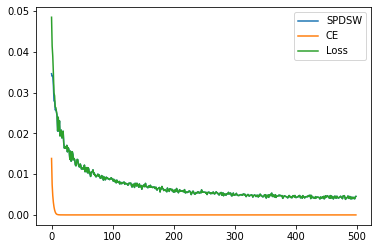

In [10]:
plt.plot(L_sw, label="SPDSW")
plt.plot(L_ce, label="CE")
plt.plot(L_loss, label="Loss")
plt.legend()
plt.show()

In [11]:
Xs, ys = get_data(1, True, "./dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(3, True, "./dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1


epochs = 500
num_projs = 500

model = Transformations(22).to(device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

classifier = MLP(d*d, 4, 50, device=device)
optimizer_clf = torch.optim.Adam(classifier.parameters(), lr=1e-2)


L_loss = []
L_sw = []
L_ce = []

L_acc_source_baseline = []
L_acc_target_baseline = []


pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,0])
    log_Xs = linalg.sym_logm(zs[:,0,]).reshape(-1, d*d)

#     sw = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
    ce = 0.01 * cross_entropy(classifier(log_Xs), ys)

    loss = ce # sw + ce

    loss.backward()
    optimizer.step()
    optimizer_clf.step()
    optimizer.zero_grad()
    optimizer_clf.zero_grad()

    L_loss.append(loss.item())
    L_ce.append(ce.item())
#     L_sw.append(sw.item())

    with torch.no_grad():
        log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
        log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)
        
        acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
        acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

        L_acc_source_baseline.append(acc_source)
        L_acc_target_baseline.append(acc_target)
        
    pbar.set_postfix_str(f"loss = {loss.item():.3f}, ce = {ce.item():.3f}, " +
                         f"acc_sc = {acc_source.item():.3f}, acc_tgt = {acc_target.item():.3f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.28it/s, loss = 0.000, ce = 0.000, acc_sc = 1.000, acc_tgt = 0.519]


In [12]:
## LR on original data
log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
clf.fit(log_Xs, ys.cpu())
score0 = clf.score(log_Xt, yt.cpu())


## LR on shifted data
log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
clf.fit(log_Xs, ys.cpu())
score1 = clf.score(log_Xt, yt.cpu())


acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

print(score0, score1, acc_target, acc_source)

0.5111111111111111 0.5111111111111111 0.5185185185185185 1.0


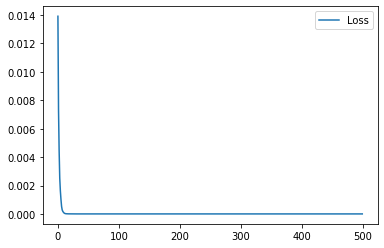

In [13]:
# plt.plot(L_ce, label="CE")
plt.plot(L_loss, label="Loss")
plt.legend()
plt.show()

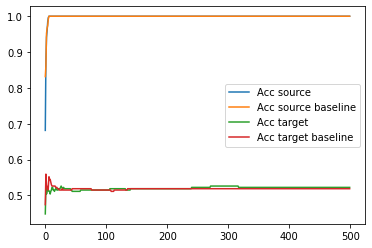

In [14]:
plt.plot(L_acc_source, label="Acc source")
plt.plot(L_acc_source_baseline, label="Acc source baseline")
plt.plot(L_acc_target, label="Acc target")
plt.plot(L_acc_target_baseline, label="Acc target baseline")
plt.legend()
plt.show()

In [15]:
Xs, ys = get_data(1, True, "./dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(1, False, "./dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1


epochs = 500
num_projs = 500

model = Transformations(22).to(device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

classifier = MLP(d*d, 4, 50, device=device)
optimizer_clf = torch.optim.Adam(classifier.parameters(), lr=1e-2)


L_loss = []
L_sw = []
L_ce = []

L_acc_source = []
L_acc_target = []


pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,0])
    log_Xs = linalg.sym_logm(zs[:,0,]).reshape(-1, d*d)

    sw = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
    ce = 0.01 * cross_entropy(classifier(log_Xs), ys)

    loss = sw + ce

    loss.backward()
    optimizer.step()
    optimizer_clf.step()
    optimizer.zero_grad()
    optimizer_clf.zero_grad()

    L_loss.append(loss.item())
    L_ce.append(ce.item())
    L_sw.append(sw.item())

    with torch.no_grad():
        log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
        log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)
        
        acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
        acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

        L_acc_source.append(acc_source)
        L_acc_target.append(acc_target)
        
    pbar.set_postfix_str(f"loss = {loss.item():.3f}, sw = {sw.item():.3f}, ce = {ce.item():.3f}, acc_sc = {acc_source.item():.3f}, acc_tgt = {acc_target.item():.3f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:02<00:00,  4.08it/s, loss = 0.001, sw = 0.001, ce = 0.000, acc_sc = 1.000, acc_tgt = 0.722]


In [16]:
## LR on original data
log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
clf.fit(log_Xs, ys.cpu())
score0 = clf.score(log_Xt, yt.cpu())


## LR on shifted data
log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
clf.fit(log_Xs, ys.cpu())
score1 = clf.score(log_Xt, yt.cpu())


acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

print(score0, score1, acc_target, acc_source)

0.7829181494661922 0.7864768683274022 0.7224199288256228 1.0


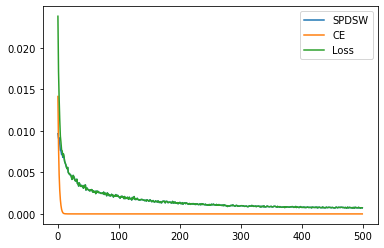

In [17]:
plt.plot(L_sw, label="SPDSW")
plt.plot(L_ce, label="CE")
plt.plot(L_loss, label="Loss")
plt.legend()
plt.show()

In [18]:
Xs, ys = get_data(1, True, "./dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(1, False, "./dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1


epochs = 500
num_projs = 500

model = Transformations(22).to(device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

classifier = MLP(d*d, 4, 50, device=device)
optimizer_clf = torch.optim.Adam(classifier.parameters(), lr=1e-2)


L_loss = []
L_sw = []
L_ce = []

L_acc_source_baseline = []
L_acc_target_baseline = []


pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,0])
    log_Xs = linalg.sym_logm(zs[:,0,]).reshape(-1, d*d)

#     sw = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
    ce = 0.01 * cross_entropy(classifier(log_Xs), ys)

    loss = ce # sw + ce

    loss.backward()
    optimizer.step()
    optimizer_clf.step()
    optimizer.zero_grad()
    optimizer_clf.zero_grad()

    L_loss.append(loss.item())
    L_ce.append(ce.item())
#     L_sw.append(sw.item())

    with torch.no_grad():
        log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
        log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)
        
        acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
        acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

        L_acc_source_baseline.append(acc_source)
        L_acc_target_baseline.append(acc_target)
        
    pbar.set_postfix_str(f"loss = {loss.item():.3f}, ce = {ce.item():.3f}, " +
                         f"acc_sc = {acc_source.item():.3f}, acc_tgt = {acc_target.item():.3f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:23<00:00, 21.01it/s, loss = 0.000, ce = 0.000, acc_sc = 1.000, acc_tgt = 0.722]


In [19]:
## LR on original data
log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
clf.fit(log_Xs, ys.cpu())
score0 = clf.score(log_Xt, yt.cpu())


## LR on shifted data
log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
clf.fit(log_Xs, ys.cpu())
score1 = clf.score(log_Xt, yt.cpu())


acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

print(score0, score1, acc_target, acc_source)

0.7829181494661922 0.7829181494661922 0.7224199288256228 1.0


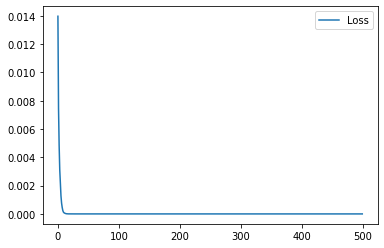

In [20]:
# plt.plot(L_ce, label="CE")
plt.plot(L_loss, label="Loss")
plt.legend()
plt.show()

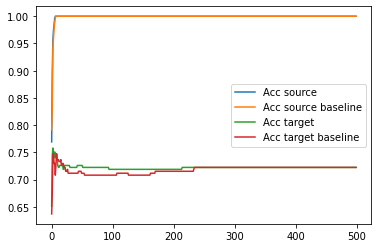

In [21]:
plt.plot(L_acc_source, label="Acc source")
plt.plot(L_acc_source_baseline, label="Acc source baseline")
plt.plot(L_acc_target, label="Acc target")
plt.plot(L_acc_target_baseline, label="Acc target baseline")
plt.legend()
plt.show()

In [22]:
class MLP(nn.Module):
    def __init__(self, d, n_c, h, device):
        super().__init__()
        self.linear1 = nn.Linear(d, h, device=device, dtype=torch.double)
        self.linear2 = nn.Linear(h, n_c, device=device, dtype=torch.double)
        self.batch_norm = nn.BatchNorm1d(d, device=device, dtype=torch.double)

    def forward(self, X):
#         out = self.batch_norm(X)
        out = F.relu(self.linear1(X))
        out = self.linear2(out)
        return out

In [23]:
Xs, ys = get_data(1, True, "./dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(1, False, "./dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1


epochs = 500
num_projs = 500

model = Transformations(22).to(device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

classifier = MLP(d*d, 4, 50, device=device)
optimizer_clf = torch.optim.Adam(classifier.parameters(), lr=1e-2)


L_loss = []
L_sw = []
L_ce = []

L_acc_source = []
L_acc_target = []


pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,0])
    log_Xs = linalg.sym_logm(zs[:,0,]).reshape(-1, d*d)

    sw = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
    ce = 0.01 * cross_entropy(classifier(log_Xs), ys)

    loss = sw + ce

    loss.backward()
    optimizer.step()
    optimizer_clf.step()
    optimizer.zero_grad()
    optimizer_clf.zero_grad()

    L_loss.append(loss.item())
    L_ce.append(ce.item())
    L_sw.append(sw.item())

    with torch.no_grad():
        log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
        log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)
        
        acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
        acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

        L_acc_source.append(acc_source)
        L_acc_target.append(acc_target)
        
    pbar.set_postfix_str(f"loss = {loss.item():.3f}, sw = {sw.item():.3f}, ce = {ce.item():.3f}, acc_sc = {acc_source.item():.3f}, acc_tgt = {acc_target.item():.3f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:03<00:00,  4.05it/s, loss = 0.001, sw = 0.001, ce = 0.000, acc_sc = 1.000, acc_tgt = 0.730]


In [24]:
## LR on original data
log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
clf.fit(log_Xs, ys.cpu())
score0 = clf.score(log_Xt, yt.cpu())


## LR on shifted data
log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
clf.fit(log_Xs, ys.cpu())
score1 = clf.score(log_Xt, yt.cpu())


acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

print(score0, score1, acc_target, acc_source)

0.7829181494661922 0.7864768683274022 0.7295373665480427 1.0


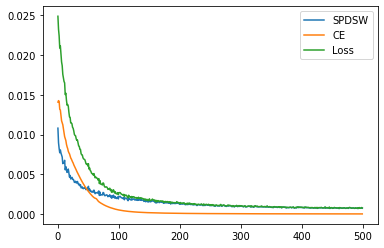

In [25]:
plt.plot(L_sw, label="SPDSW")
plt.plot(L_ce, label="CE")
plt.plot(L_loss, label="Loss")
plt.legend()
plt.show()

In [26]:
Xs, ys = get_data(1, True, "./dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(1, False, "./dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1


epochs = 500
num_projs = 500

model = Transformations(22).to(device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

classifier = MLP(d*d, 4, 50, device=device)
optimizer_clf = torch.optim.Adam(classifier.parameters(), lr=1e-2)


L_loss = []
L_sw = []
L_ce = []

L_acc_source_baseline = []
L_acc_target_baseline = []


pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,0])
    log_Xs = linalg.sym_logm(zs[:,0,]).reshape(-1, d*d)

#     sw = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
    ce = 0.01 * cross_entropy(classifier(log_Xs), ys)

    loss = ce # sw + ce

    loss.backward()
    optimizer.step()
    optimizer_clf.step()
    optimizer.zero_grad()
    optimizer_clf.zero_grad()

    L_loss.append(loss.item())
    L_ce.append(ce.item())
#     L_sw.append(sw.item())

    with torch.no_grad():
        log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
        log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)
        
        acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
        acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

        L_acc_source_baseline.append(acc_source)
        L_acc_target_baseline.append(acc_target)
        
    pbar.set_postfix_str(f"loss = {loss.item():.3f}, ce = {ce.item():.3f}, " +
                         f"acc_sc = {acc_source.item():.3f}, acc_tgt = {acc_target.item():.3f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 21.82it/s, loss = 0.000, ce = 0.000, acc_sc = 1.000, acc_tgt = 0.726]


In [27]:
## LR on original data
log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
clf.fit(log_Xs, ys.cpu())
score0 = clf.score(log_Xt, yt.cpu())


## LR on shifted data
log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
clf.fit(log_Xs, ys.cpu())
score1 = clf.score(log_Xt, yt.cpu())


acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

print(score0, score1, acc_target, acc_source)

0.7829181494661922 0.7793594306049823 0.7259786476868327 1.0


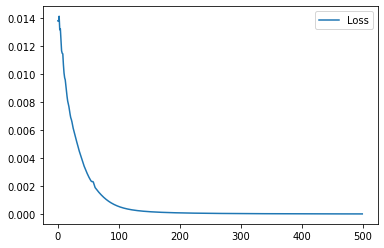

In [28]:
# plt.plot(L_ce, label="CE")
plt.plot(L_loss, label="Loss")
plt.legend()
plt.show()

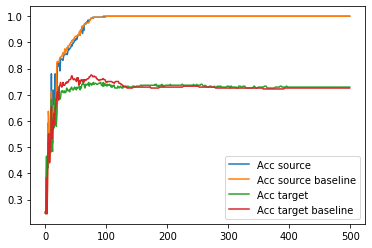

In [29]:
plt.plot(L_acc_source, label="Acc source")
plt.plot(L_acc_source_baseline, label="Acc source baseline")
plt.plot(L_acc_target, label="Acc target")
plt.plot(L_acc_target_baseline, label="Acc target baseline")
plt.legend()
plt.show()

In [41]:
results0 = np.zeros((5,5))
results1 = np.zeros((5,5))

results1_clf = np.zeros((5,5))

d = 22

cross_entropy = torch.nn.CrossEntropyLoss()


for i, s1 in enumerate([1,3,7,8,9]):
    for j, s2 in enumerate([1,3,7,8,9]):
        if s1 != s2:
            Xs, ys = get_data(s1, True, "./dataset/")
            cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
            ys = torch.tensor(ys, device=device, dtype=torch.long)-1

            Xt, yt = get_data(s2, True, "./dataset/")
            cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
            yt = torch.tensor(yt, device=device, dtype=torch.long)-1


            epochs = 500
            num_projs = 500

            model = SPDNet(22).to(device)
            optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
            # optimizer = RiemannianAdam(model.parameters(), lr=1e-1)
            
            classifier = MLP(d*d, 4, 50, device=device)
            optimizer_clf = torch.optim.Adam(classifier.parameters(), lr=1e-2)


            L_loss = []

            pbar = trange(epochs)

            for e in pbar:
                zs = model(cov_Xs[:,:,0])
                log_Xs = linalg.sym_logm(zs[:,0,]).reshape(-1, d*d)
                
                sw = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,0], num_projs, device, p=2)
                ce = 0.01 * cross_entropy(classifier(log_Xs), ys)
                
                loss = sw + ce

                loss.backward()
                optimizer.step()
                optimizer_clf.step()
                optimizer.zero_grad()
                optimizer_clf.zero_grad()

                L_loss.append(loss.item())

                pbar.set_postfix_str(f"loss = {loss.item():.3f}")



            ## LR on original data
            log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score0 = clf.score(log_Xt, yt.cpu())


            ## LR on shifted data
            log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
            log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

            clf = make_pipeline(GridSearchCV(SVC(), {"C": np.logspace(-2, 2, 10)}, n_jobs=10))
            clf.fit(log_Xs, ys.cpu())
            score1 = clf.score(log_Xt, yt.cpu())

            results0[i,j] = score0
            results1[i,j] = score1
            
            acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
            acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

            results1_clf[i,j] = acc_target
            
            print(s1, s2, score0, score1, acc_target)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:55<00:00,  1.69it/s, loss = 0.012]


1 3 0.5111111111111111 0.6074074074074074 0.5074074074074074


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:48<00:00,  1.43it/s, loss = 0.009]


1 7 0.3173431734317343 0.45018450184501846 0.36531365313653136


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:32<00:00,  1.27it/s, loss = 0.010]


1 8 0.30303030303030304 0.6212121212121212 0.5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:07<00:00,  1.36it/s, loss = 0.018]


1 9 0.25316455696202533 0.4810126582278481 0.4008438818565401


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:56<00:00,  1.05it/s, loss = 0.011]


3 1 0.3553113553113553 0.6373626373626373 0.4945054945054945


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:44<00:00,  1.05s/it, loss = 0.014]


3 7 0.24354243542435425 0.5793357933579336 0.41697416974169743


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [10:28<00:00,  1.26s/it, loss = 0.011]


3 8 0.4015151515151515 0.6515151515151515 0.6325757575757576


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:07<00:00,  1.36it/s, loss = 0.011]


3 9 0.28270042194092826 0.5611814345991561 0.5063291139240507


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:38<00:00,  1.04s/it, loss = 0.009]


7 1 0.43956043956043955 0.41025641025641024 0.3882783882783883


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [10:51<00:00,  1.30s/it, loss = 0.014]


7 3 0.45185185185185184 0.5407407407407407 0.4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:11<00:00,  1.10s/it, loss = 0.010]


7 8 0.2803030303030303 0.3522727272727273 0.3181818181818182


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:51<00:00,  1.21it/s, loss = 0.022]


7 9 0.2616033755274262 0.4810126582278481 0.39662447257383965


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:42<00:00,  1.24it/s, loss = 0.009]


8 1 0.304029304029304 0.5238095238095238 0.4652014652014652


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:19<00:00,  1.14it/s, loss = 0.011]


8 3 0.2814814814814815 0.7074074074074074 0.6222222222222222


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:37<00:00,  1.09it/s, loss = 0.010]


8 7 0.2656826568265683 0.41697416974169743 0.3837638376383764


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:21<00:00,  1.00s/it, loss = 0.016]


8 9 0.3291139240506329 0.5822784810126582 0.510548523206751


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:37<00:00,  1.09it/s, loss = 0.018]


9 1 0.26373626373626374 0.5054945054945055 0.4358974358974359


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [08:12<00:00,  1.01it/s, loss = 0.011]


9 3 0.3148148148148148 0.6296296296296297 0.4888888888888889


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [07:17<00:00,  1.14it/s, loss = 0.022]


9 7 0.24723247232472326 0.3874538745387454 0.33948339483394835


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:05<00:00,  1.64it/s, loss = 0.016]


9 8 0.3560606060606061 0.571969696969697 0.5227272727272727


In [42]:
results1

array([[0.        , 0.60740741, 0.4501845 , 0.62121212, 0.48101266],
       [0.63736264, 0.        , 0.57933579, 0.65151515, 0.56118143],
       [0.41025641, 0.54074074, 0.        , 0.35227273, 0.48101266],
       [0.52380952, 0.70740741, 0.41697417, 0.        , 0.58227848],
       [0.50549451, 0.62962963, 0.38745387, 0.5719697 , 0.        ]])

In [43]:
results0

array([[0.        , 0.51111111, 0.31734317, 0.3030303 , 0.25316456],
       [0.35531136, 0.        , 0.24354244, 0.40151515, 0.28270042],
       [0.43956044, 0.45185185, 0.        , 0.28030303, 0.26160338],
       [0.3040293 , 0.28148148, 0.26568266, 0.        , 0.32911392],
       [0.26373626, 0.31481481, 0.24723247, 0.35606061, 0.        ]])

In [44]:
results1_clf

array([[0.        , 0.50740741, 0.36531365, 0.5       , 0.40084388],
       [0.49450549, 0.        , 0.41697417, 0.63257576, 0.50632911],
       [0.38827839, 0.4       , 0.        , 0.31818182, 0.39662447],
       [0.46520147, 0.62222222, 0.38376384, 0.        , 0.51054852],
       [0.43589744, 0.48888889, 0.33948339, 0.52272727, 0.        ]])

In [45]:
for k, row in enumerate(results0):
    print(k, np.sum(row)/4)

0 0.3461622861337934
1 0.32076734104794735
2 0.35832967431068696
3 0.29507684159699665
4 0.29546103923410194


In [46]:
for k, row in enumerate(results1):
    print(k, np.sum(row)/4)

0 0.5399541721730987
1 0.6073487542087196
2 0.4460706341244316
3 0.5576173954928217
4 0.5236369266581444


In [47]:
for k, row in enumerate(results1_clf):
    print(k, np.sum(row)/4)

0 0.4433912356001197
1 0.5125961339367501
2 0.37577116975851155
3 0.4954340120672038
4 0.4467492480868865
